# L1 - Lista de Exercícios 1

__Objetivo:__ Desenvolver e revisar os conteúdos desenvolvidos até então no modulo;

__Conteúdo:__ Serão 2 Exercícios obrigatórios (8 pontos) e um extra opcional (2 pontos), totalizando 10 pontos;

__Forma de Entrega:__ _Jupyter Notebook_ individualmente pelo _Class_;

__Data Limite para entrega:__ até o dia 05/08/2022;

__Obs:__ O tempo de aula hoje será exclusivamente para o desenvolvimento dos exercícios e monitoria de dúvidas sobre os exercícios.

<br>

__E1__ Utilizando o _dataset_ `sports` disponibilizado no _drive_, desenvolva os tópicos a seguir:

- Limpeza e tratamento dos dados;
- Análise Exploratória dos Dados;
- Identificação do Modelo de _Machine Learning_ mais adequado para a aplicação (Regressão ou classificação);
- Execução do modelo escolhido e levantamento das métricas;

<br>

__E2__ Utilizando ao _dataset_ `insurance.csv`disponibilizado no _drive_, desenvolva os tópicos a seguir:

- Limpeza e tratamento dos dados;
- Análise Exploratória dos Dados;
- Utilize um modelo de Regressão Linear para chegar nos valores de seguros cobrados;
- Utilize agora um modelo de Regressão Logística para fazer a classificação das classes de seguros;

__DICA:__ As classes de seguros precisam ser criadas (não existe no _dataset_). Desenvolva a _target_ explorando a relação entre os valores cobrados pela idade dos segurados. 

<br>

__EE__ Dando continuidade ao exercício desenvolvido sobre o _dataset_ `COVID`, ou seja, após a limpeza dos dados e análise exploratória dos dados (isso não precisa ter nesse exercício, só a base já tratada). Desenvolva os tópicos a seguir:

 - Utilize uma Regressão Logística para as predições de resultados positivos de COVID;
 - A partir do _F1-Score_, determine o valor ideal de limiar de corte (_threshold_) para que se minimize os Falsos Negativos.
 
 <br>

In [ ]:
#link = 'https://drive.google.com/open?id=12LpCQ8fVeOKHKWChFDVohDfU9nAL-eTy' # The shareable link
##

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import r2_score

%matplotlib inline
pd.set_option('display.max_columns', None)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Criando funções importantes

def import_drive_file(link, sep):
    """ Cria processo de importação de datasets do Drive para um Data Frame no Colab"""
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    fluff, id = link.split('=')
    print (id) # Verify that you have everything after '='

    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('Filename.csv')  
    df = pd.read_csv('Filename.csv', sep=sep)
    return df

def plt_correlacao_entre_vars_num(df, col_num, method="spearman"):
    """ Cria gráfico de correlação entre as variáveis"""
    corr=df[col_num].corr(method=method)

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap = True)

    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(15, 13))
        ax = sns.heatmap(corr, mask=mask, cmap = cmap, square=True, #annot = True, 
                        linewidths = .5, cbar_kws = {"shrink": .5})
        plt.title('Correlação entre as variáveis Numéricas')

def correlacao_entre_vars_num(df, col_num, method="spearman"):
    corrmat = df[col_num].corr(method=method)
    corrmat = corrmat.abs().unstack() # absolute value of corr coef
    corrmat = corrmat.sort_values(ascending=False)
    corrmat = corrmat[corrmat >= 0.8]
    corrmat = corrmat[corrmat < 1]
    corrmat = pd.DataFrame(corrmat).reset_index()
    corrmat.columns = ['feature1', 'feature2', 'corr']

    grouped_feature_ls = []
    correlated_groups = []

    for feature in corrmat.feature1.unique():
        
        if feature not in grouped_feature_ls:

            # find all features correlated to a single feature
            correlated_block = corrmat[corrmat.feature1 == feature]
            grouped_feature_ls = grouped_feature_ls + list(
                correlated_block.feature2.unique()) + [feature]

            # append the block of features to the list
            correlated_groups.append(correlated_block)

    print('found {} correlated groups in numeric variables'.format(len(correlated_groups)))
    print('out of {} total features'.format(df.shape[1]))
    print(corrmat)
    print(correlated_groups)

## EX1

In [ ]:
# Importando os dados
df_sports = import_drive_file(link='https://drive.google.com/open?id=1mchCbE-VysPVuPM0NKNOSJhzNFyYN_Wh', sep=",")

1mchCbE-VysPVuPM0NKNOSJhzNFyYN_Wh


### EDA

In [ ]:
# Separa variáveis numéricas para facilitar análises quando necessário
col_num = [var for var in df_sports.columns if df_sports[var].dtype == 'float64' or df_sports[var].dtype == 'int64']
col_num

['GamesPlayed',
 'MinutesPlayed',
 'PointsPerGame',
 'FieldGoalsMade',
 'FieldGoalsAttempt',
 'FieldGoalPercent',
 '3PointMade',
 '3PointAttempt',
 '3PointPercent',
 'FreeThrowMade',
 'FreeThrowAttempt',
 'FreeThrowPercent',
 'OffensiveRebounds',
 'DefensiveRebounds',
 'Rebounds',
 'Assists',
 'Steals',
 'Blocks',
 'Turnovers',
 'Target']

#### Tratamento dos dados

In [ ]:
# Apresentando as primeiras 5 linhas
df_sports.head()

,Name,GamesPlayed,MinutesPlayed,PointsPerGame,FieldGoalsMade,FieldGoalsAttempt,FieldGoalPercent,3PointMade,3PointAttempt,3PointPercent,FreeThrowMade,FreeThrowAttempt,FreeThrowPercent,OffensiveRebounds,DefensiveRebounds,Rebounds,Assists,Steals,Blocks,Turnovers,Target
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,1.6,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,2.6,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,0.9,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,0.9,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,1.3,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1


In [ ]:
# Visualiza o nome das colunas, o tipo de cada uma e se existem alguns dados nulos
df_sports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               1340 non-null   object 
 1   GamesPlayed        1340 non-null   int64  
 2   MinutesPlayed      1340 non-null   float64
 3   PointsPerGame      1340 non-null   float64
 4   FieldGoalsMade     1340 non-null   float64
 5   FieldGoalsAttempt  1340 non-null   float64
 6   FieldGoalPercent   1340 non-null   float64
 7   3PointMade         1340 non-null   float64
 8   3PointAttempt      1340 non-null   float64
 9   3PointPercent      1329 non-null   float64
 10  FreeThrowMade      1340 non-null   float64
 11  FreeThrowAttempt   1340 non-null   float64
 12  FreeThrowPercent   1340 non-null   float64
 13  OffensiveRebounds  1340 non-null   float64
 14  DefensiveRebounds  1340 non-null   float64
 15  Rebounds           1340 non-null   float64
 16  Assists            1340 

In [ ]:
# O dataframe possui 1.340 linhas e 21 colunas no total
df_sports.shape

(1340, 21)

In [ ]:
# As classes não são muito desbalanceadas, por isso não precisamos fazer nenhum tipo de balanceamento.
df_sports["Target"].value_counts(normalize=True)

1    0.620149
0    0.379851
Name: Target, dtype: float64

In [ ]:
# Verifica valores duplicados
df_sports.duplicated().value_counts()

False    1328
True       12
dtype: int64

Temos 12 registros duplicados na tabela. Vamos observaer quais são eles.

In [ ]:
df_sports[df_sports.duplicated()]

,Name,GamesPlayed,MinutesPlayed,PointsPerGame,FieldGoalsMade,FieldGoalsAttempt,FieldGoalPercent,3PointMade,3PointAttempt,3PointPercent,FreeThrowMade,FreeThrowAttempt,FreeThrowPercent,OffensiveRebounds,DefensiveRebounds,Rebounds,Assists,Steals,Blocks,Turnovers,Target
163,Charles Smith,60,8.7,2.9,1.0,2.2,44.4,0.0,0.1,0.0,0.9,1.3,69.7,0.2,0.9,1.2,1.7,0.6,0.1,0.6,1
166,Charles Smith,71,30.4,16.3,6.1,12.4,49.5,0.0,0.0,0.0,4.0,5.5,72.5,2.4,4.1,6.5,1.5,1.0,1.3,2.1,1
169,Charles Smith,34,8.6,3.5,1.4,3.7,39.2,0.4,1.4,31.9,0.2,0.3,54.5,0.4,0.4,0.8,0.6,0.3,0.2,0.8,1
243,Reggie Williams,35,24.5,10.4,4.3,12.2,35.6,0.4,1.7,22.4,1.4,1.9,72.7,1.6,1.8,3.4,1.7,0.8,0.6,1.8,1
339,Ken Johnson,64,12.7,4.1,1.8,3.3,52.8,0.0,0.0,NaN,0.6,1.3,43.5,1.4,2.4,3.8,0.3,0.2,0.3,0.9,0
366,Charles Jones,78,20.1,8.4,3.0,5.8,52.0,0.0,0.1,0.0,2.3,3.6,64.8,1.8,3.3,5.1,1.6,0.6,0.8,1.8,0
369,Charles Jones,29,16.4,3.7,1.3,4.2,31.7,0.7,2.1,31.1,0.4,0.8,50.0,0.3,1.1,1.4,1.4,0.6,0.2,1.0,0
504,Eddie Johnson,74,20.5,9.3,4.0,8.7,45.9,0.0,0.1,9.1,1.3,2.0,66.4,1.7,2.6,4.4,1.5,0.7,0.2,1.3,1
733,Gerald Henderson,43,8.3,2.6,0.9,2.4,35.6,0.1,0.4,21.1,0.8,1.1,74.5,0.3,0.9,1.3,0.3,0.2,0.2,0.3,1
824,Marcus Williams,79,16.6,6.8,2.6,6.7,39.5,0.6,2.1,28.2,0.9,1.1,84.7,0.4,1.7,2.1,3.3,0.4,0.0,1.8,0


Por serem apenas 12 e terem o potencial de trazer ruído para o modelo final, vamos deleta-los do dataframe.

In [ ]:
# Remove os registros duplicados
df_sports.drop_duplicates(keep='first', inplace=True)

In [ ]:
# Apenas a coluna 3PointPercent possui valores nulos. Valos observar o que esse registros tem em comum para pensar numa estratégia de tratamento dos mesmos
df_sports.isna().sum()

Name                  0
GamesPlayed           0
MinutesPlayed         0
PointsPerGame         0
FieldGoalsMade        0
FieldGoalsAttempt     0
FieldGoalPercent      0
3PointMade            0
3PointAttempt         0
3PointPercent        10
FreeThrowMade         0
FreeThrowAttempt      0
FreeThrowPercent      0
OffensiveRebounds     0
DefensiveRebounds     0
Rebounds              0
Assists               0
Steals                0
Blocks                0
Turnovers             0
Target                0
dtype: int64

In [ ]:
df_sports[df_sports["3PointPercent"].isna()]

,Name,GamesPlayed,MinutesPlayed,PointsPerGame,FieldGoalsMade,FieldGoalsAttempt,FieldGoalPercent,3PointMade,3PointAttempt,3PointPercent,FreeThrowMade,FreeThrowAttempt,FreeThrowPercent,OffensiveRebounds,DefensiveRebounds,Rebounds,Assists,Steals,Blocks,Turnovers,Target
338,Ken Johnson,64,12.7,4.1,1.8,3.3,52.8,0.0,0.0,NaN,0.6,1.3,43.5,1.4,2.4,3.8,0.3,0.2,0.3,0.9,0
340,Pete Williams,53,10.8,2.8,1.3,2.1,60.4,0.0,0.0,NaN,0.3,0.8,42.5,0.9,1.9,2.8,0.3,0.4,0.4,0.4,0
358,Melvin Turpin,79,24.7,10.6,4.6,9.0,51.1,0.0,0.0,NaN,1.4,1.8,78.4,2.0,3.8,5.7,0.5,0.5,1.1,1.5,1
386,Jim Petersen,60,11.9,3.2,1.2,2.4,48.6,0.0,0.0,NaN,0.8,1.1,75.8,0.7,1.7,2.5,0.5,0.2,0.5,1.2,1
397,Tom Scheffler,39,6.9,1.3,0.5,1.3,41.2,0.0,0.0,NaN,0.3,0.5,50.0,0.5,1.5,1.9,0.3,0.2,0.3,0.4,0
507,Sam Williams,59,18.2,6.1,2.6,4.7,55.6,0.0,0.0,NaN,0.8,1.5,55.1,1.5,3.7,5.2,0.6,0.8,1.3,1.1,0
509,Kurt Nimphius,63,17.2,5.3,2.2,4.7,46.1,0.0,0.0,NaN,1.0,1.7,58.3,1.5,3.2,4.7,1.0,0.3,1.3,0.9,1
510,Pete Verhoeven,71,17.0,4.9,2.1,4.2,50.3,0.0,0.0,NaN,0.7,1.0,70.8,1.5,2.1,3.6,0.7,0.6,0.3,0.8,1
521,Jim Smith,72,11.9,2.9,1.2,2.3,50.9,0.0,0.0,NaN,0.5,1.2,45.9,1.0,1.5,2.5,0.6,0.3,0.7,0.7,0
559,Jeff Wilkins,56,18.9,4.7,2.1,4.6,45.0,0.0,0.0,NaN,0.5,0.7,67.5,1.1,3.8,4.9,0.7,0.6,0.8,1.1,1


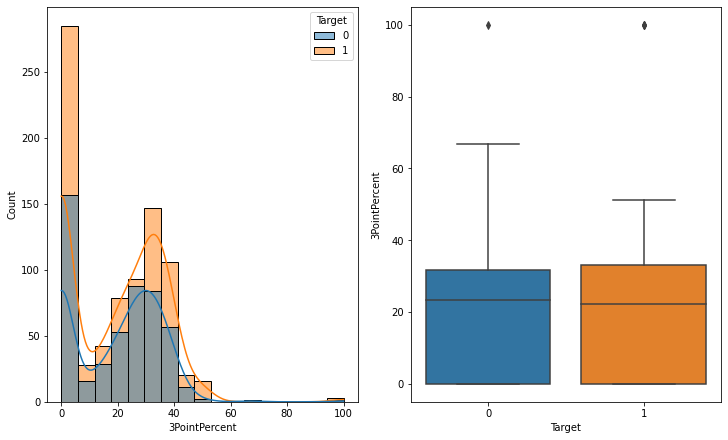

In [ ]:
# Observando a distrubuição das variáveis 3PointPercent frente a Target, as distruibuições das curvas possuem o mesmo formato e o Boxplot tbm é muito similar.
# Vamos observar a média, moda e mediana para ver se podemos partir para uma inputação de dados
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), constrained_layout=True)
    
sns.histplot(data=df_sports, x = "3PointPercent", kde=True, hue="Target", ax=ax1)
sns.boxplot(data=df_sports, x= 'Target', y = "3PointPercent", ax=ax2)
plt.show()

In [ ]:
# Como a média e a mediana estão muito próximas, vamos substituir os 10 valores nulos pela mediana. 
print("Moda:",df_sports['3PointPercent'].mean())
print("Média:",df_sports['3PointPercent'].mode())
print("Mediana:",df_sports['3PointPercent'].median())

Moda: 19.32298937784522
Média: 0    0.0
dtype: float64
Mediana: 22.45


In [ ]:
# Substituindo valores nulos da variável 3PointPercent pela mediana
df_sports['3PointPercent'].fillna(df_sports['3PointPercent'].median(), inplace=True)

In [ ]:
# Podemos também excluir a coluna com o Nome dos jogadores, tendo em vista que ela não usabilidade na modelagem
df_sports.drop(['Name'], axis = 1, inplace=True)

#### Análise Gráfica

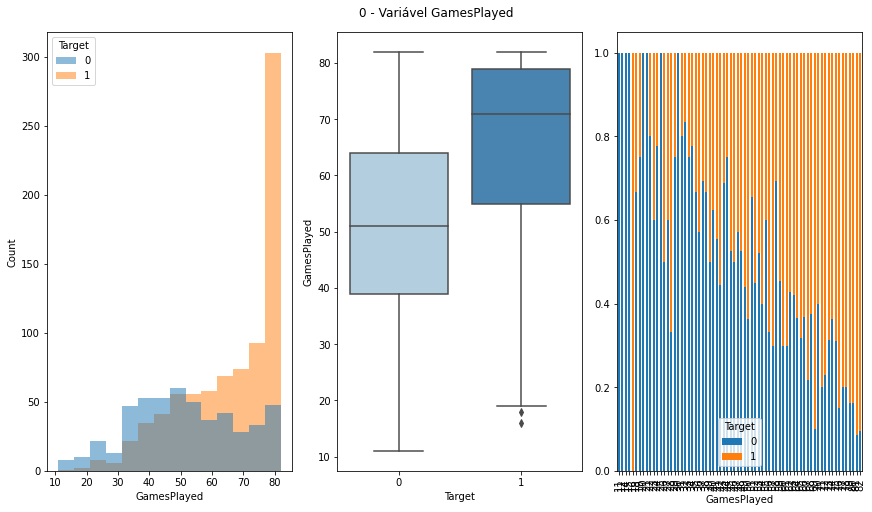

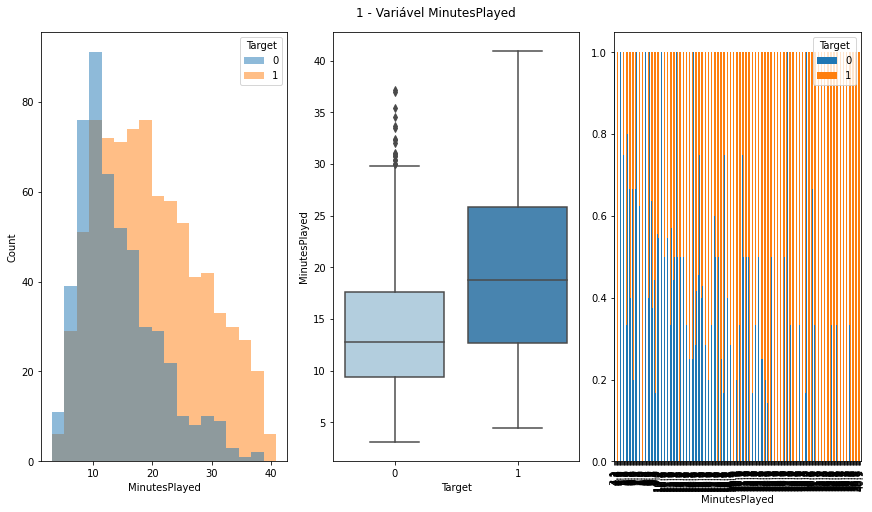

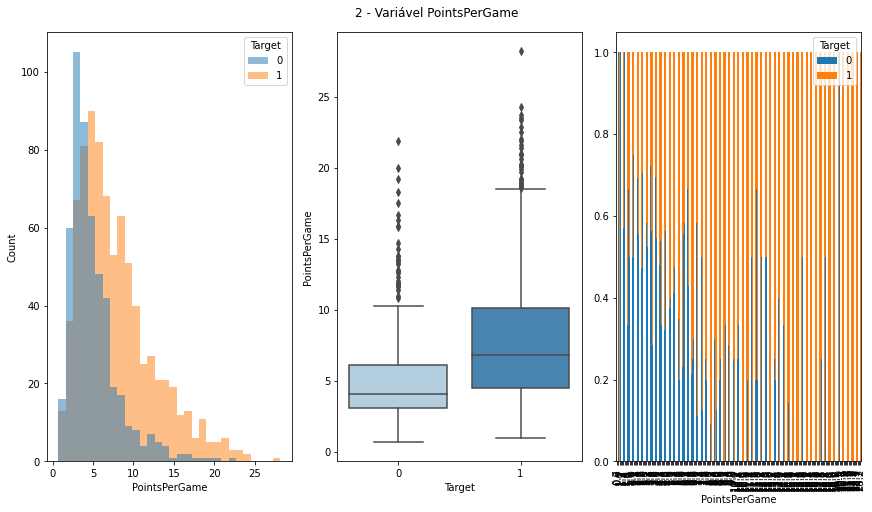

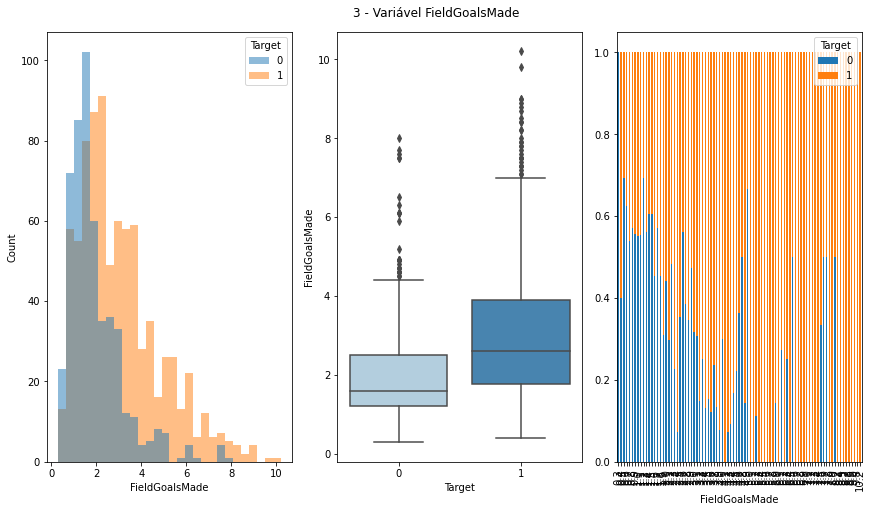

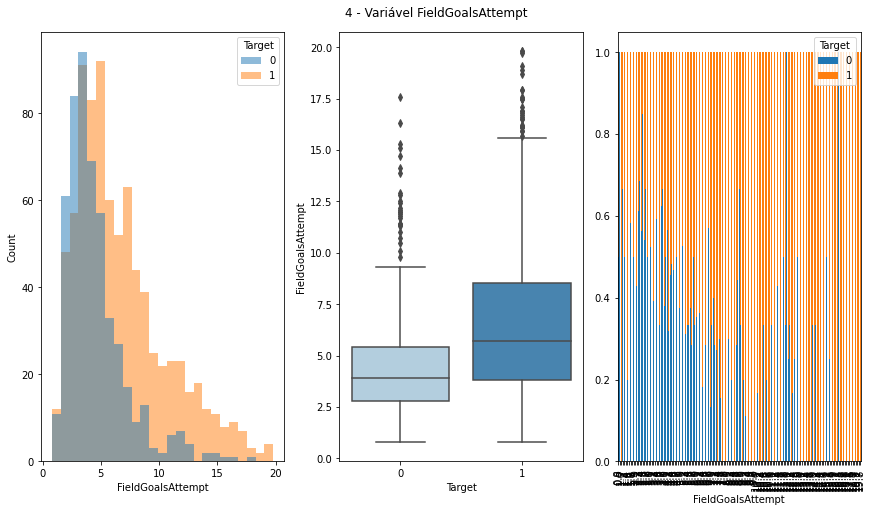

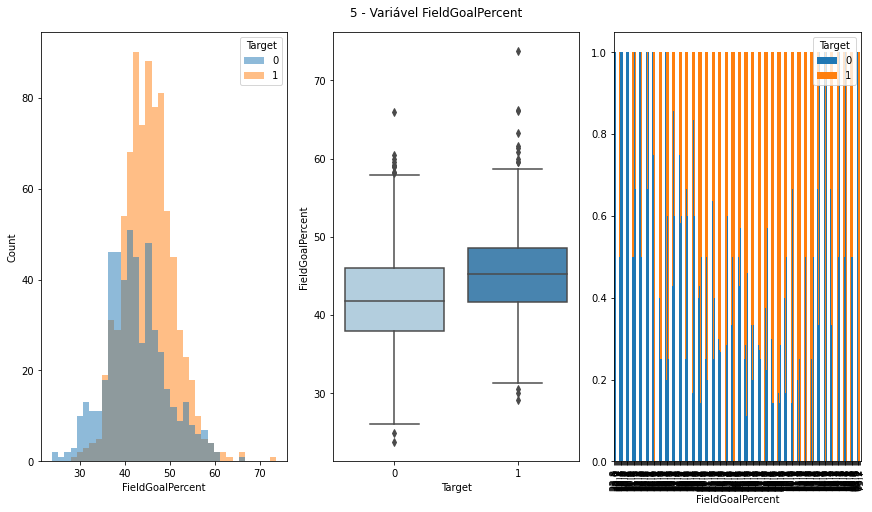

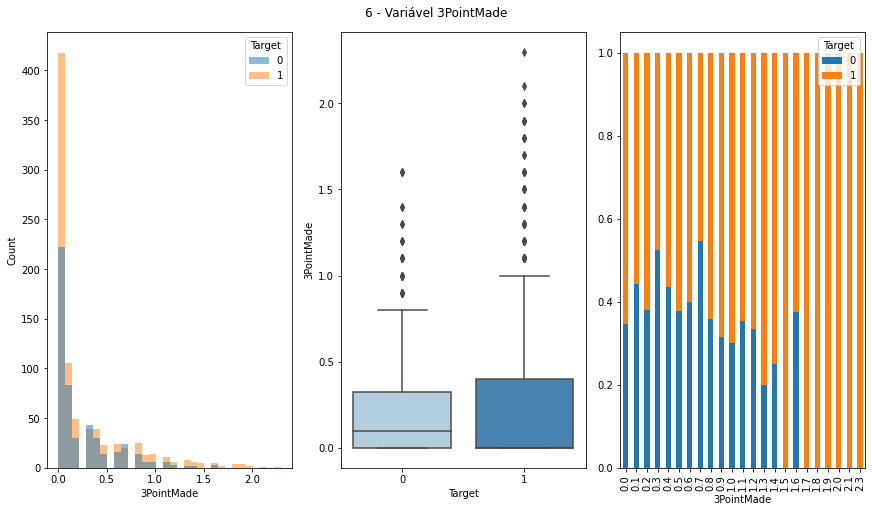

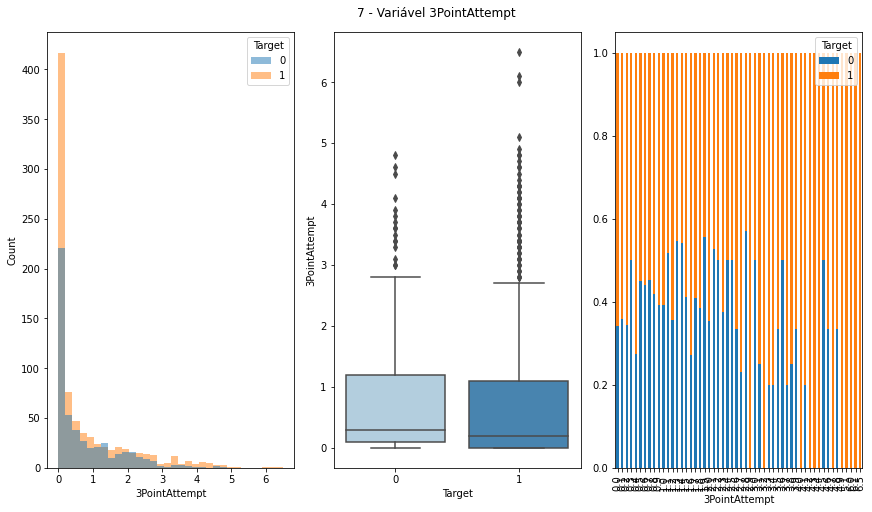

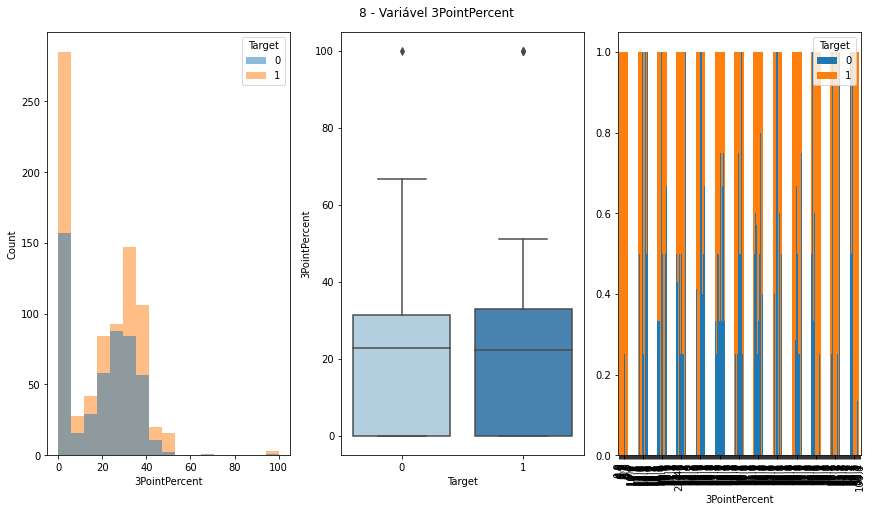

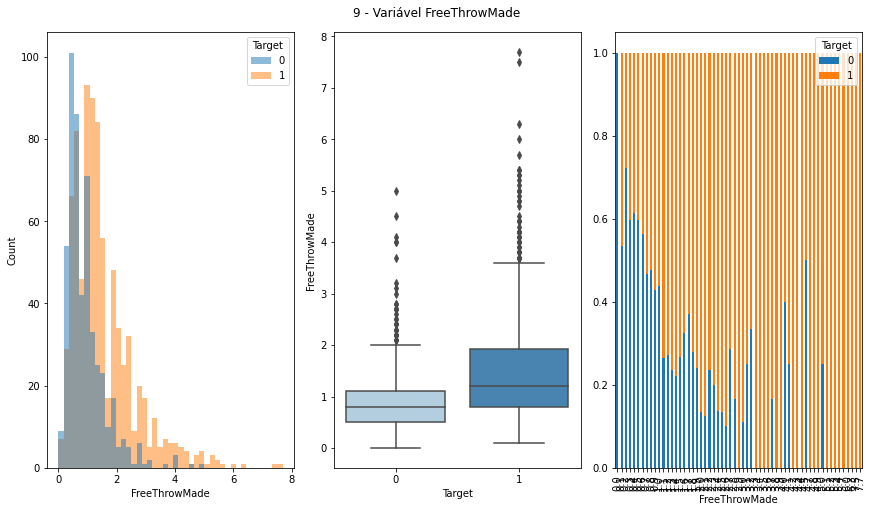

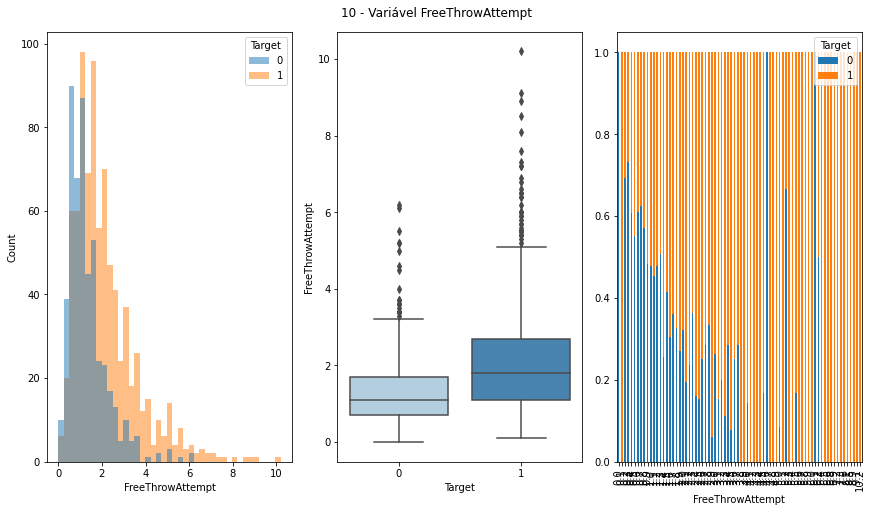

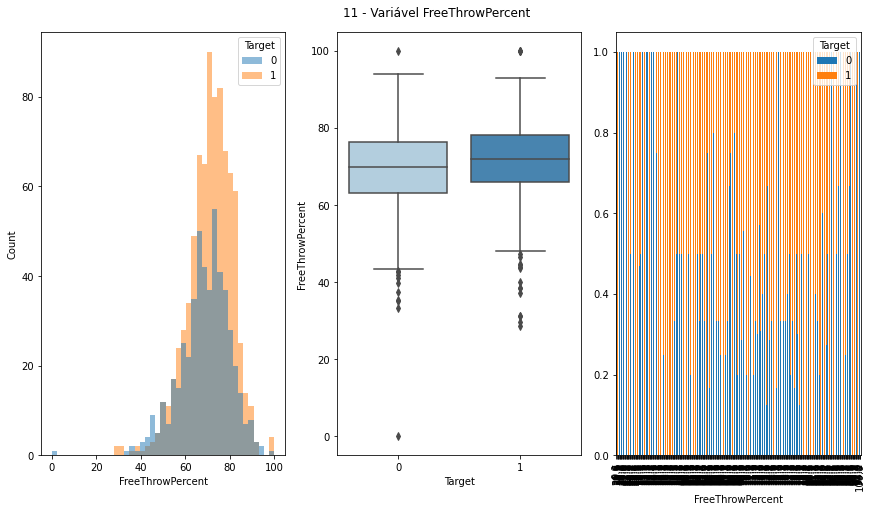

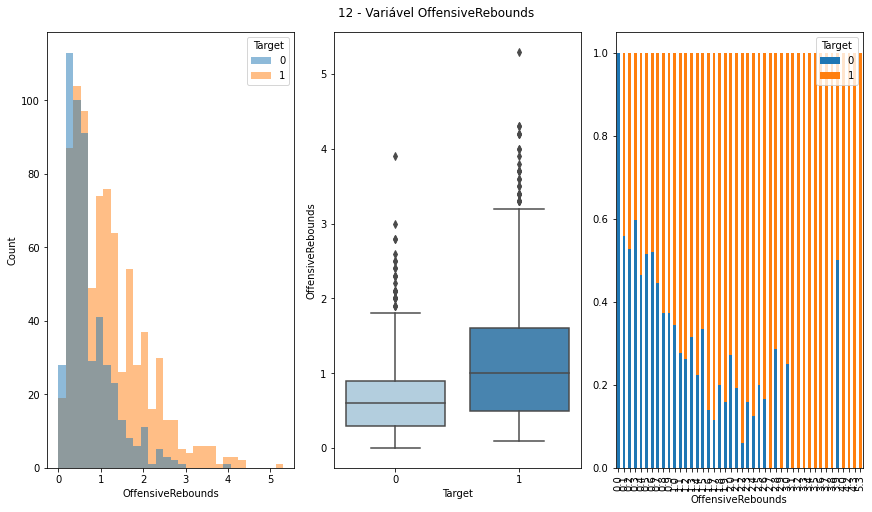

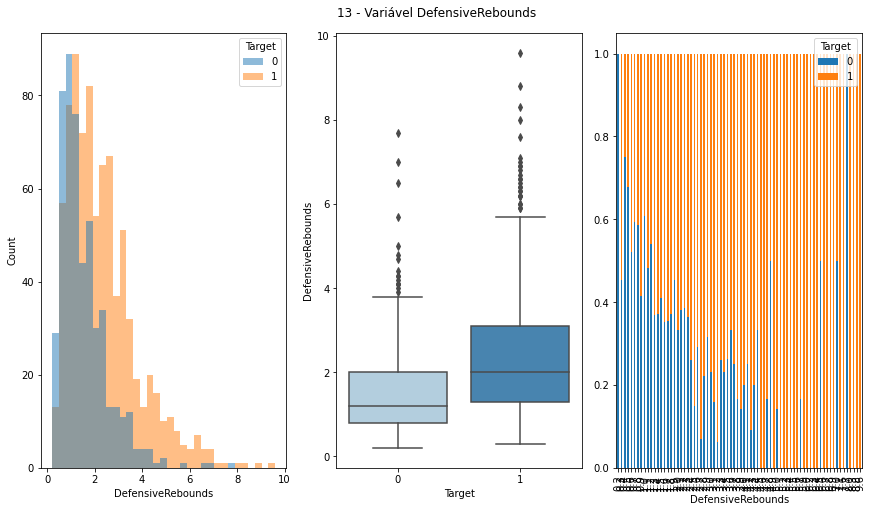

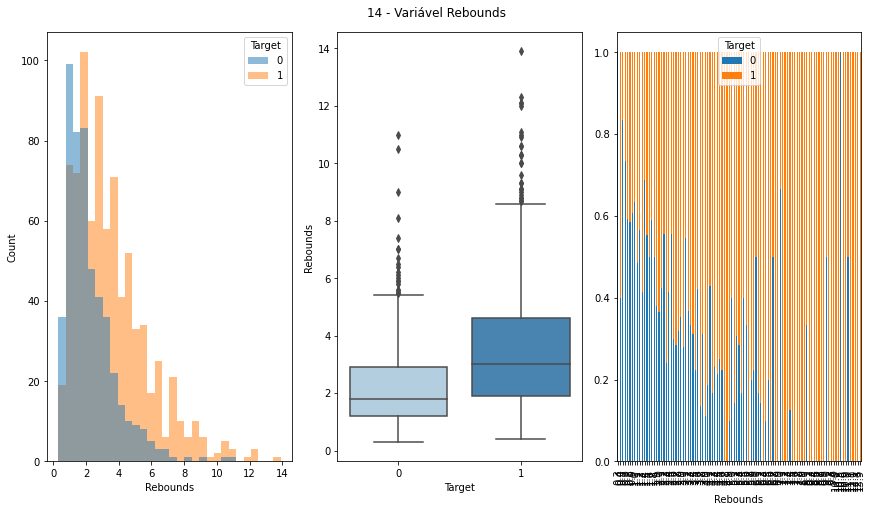

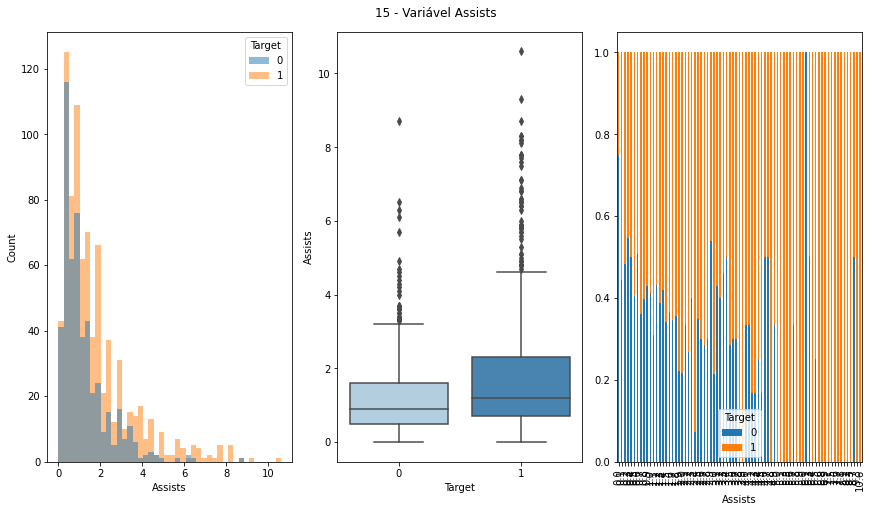

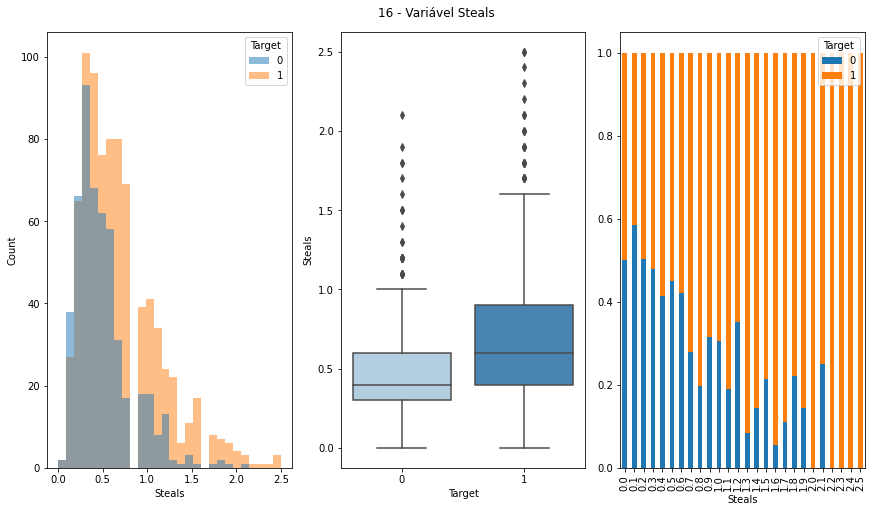

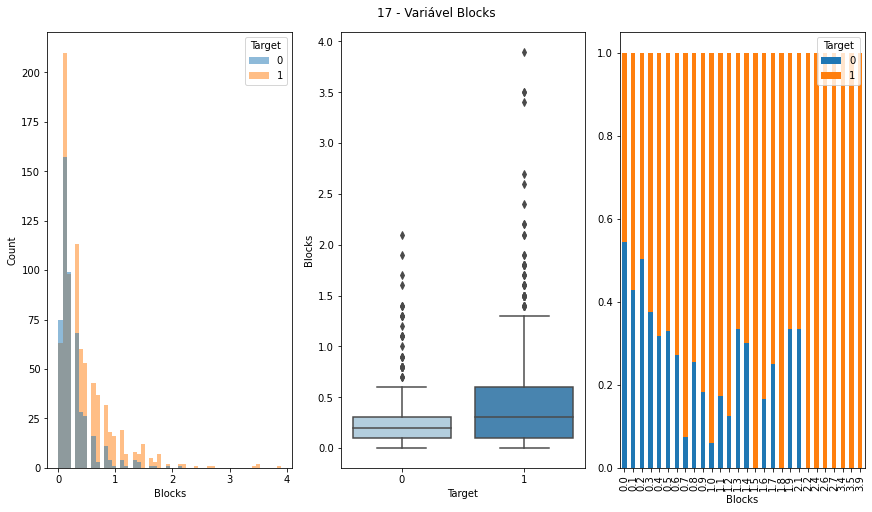

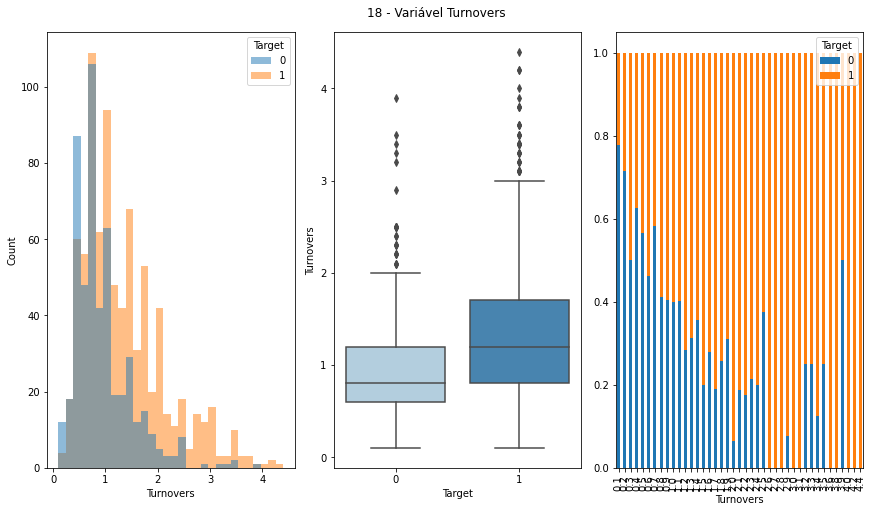

In [ ]:
# Os gráfico abaixo mostram a relação de cada variável com a variável resposta
for i, var in enumerate(col_num):
    if var != 'Target':
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 7), constrained_layout=True)

        df_sports.groupby(var)['Target'].value_counts(normalize=True).unstack('Target').plot.bar(stacked=True, ax=ax3)
        sns.histplot(df_sports,x=var, lw=0., hue='Target', ax=ax1)
        sns.boxplot(data=df_sports, x = 'Target', y=var,  palette="Blues", ax=ax2)
        fig.suptitle('{0} - Variável {1}'.format(i, var))
        plt.show()

Observando uma a uma pela diferença nas ditribuições das variáveis pela Target, todas as variáveis parecem possui alguma relação com a variável alvo, em maior ou menor grau. Isso nos indica que nesse primeiro momento não há motivos para remoção de variáveis. Vamos análisar a correlação entre as variáveis explicativas para entender se existe a possibilidade de exclusção de algumas variáveis possivelmente redundantes afim de diminuir a complexidade do modelo.

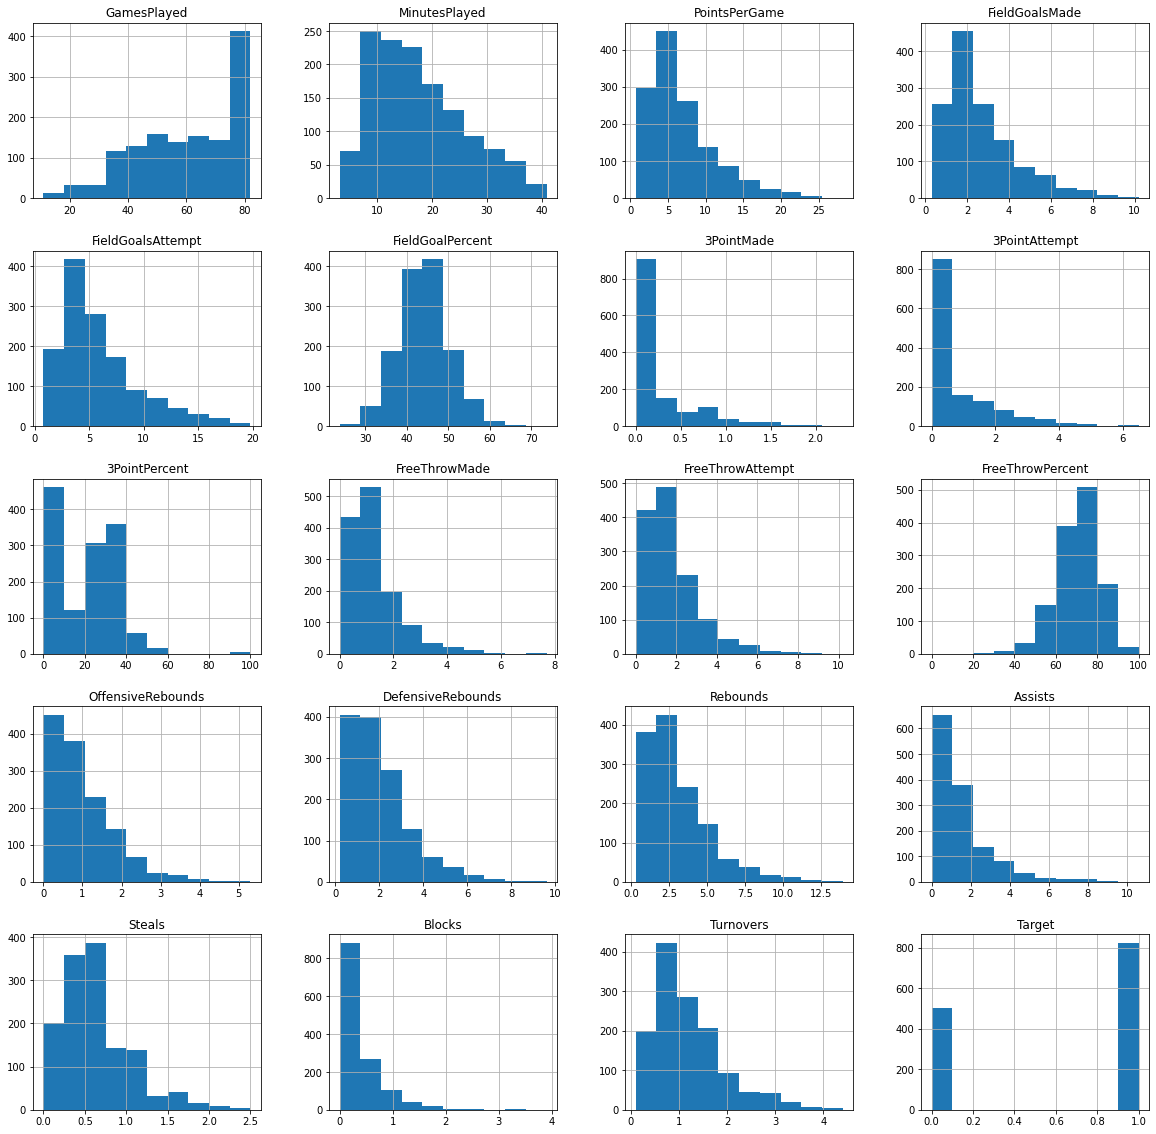

In [ ]:
# Analisando a distribuição das variáveis sem a variável Target
df_sports[col_num].hist(figsize=(20,20))
plt.show()
#sns.pairplot(df_sports[col_num].sample(100), hue="Target")
#plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


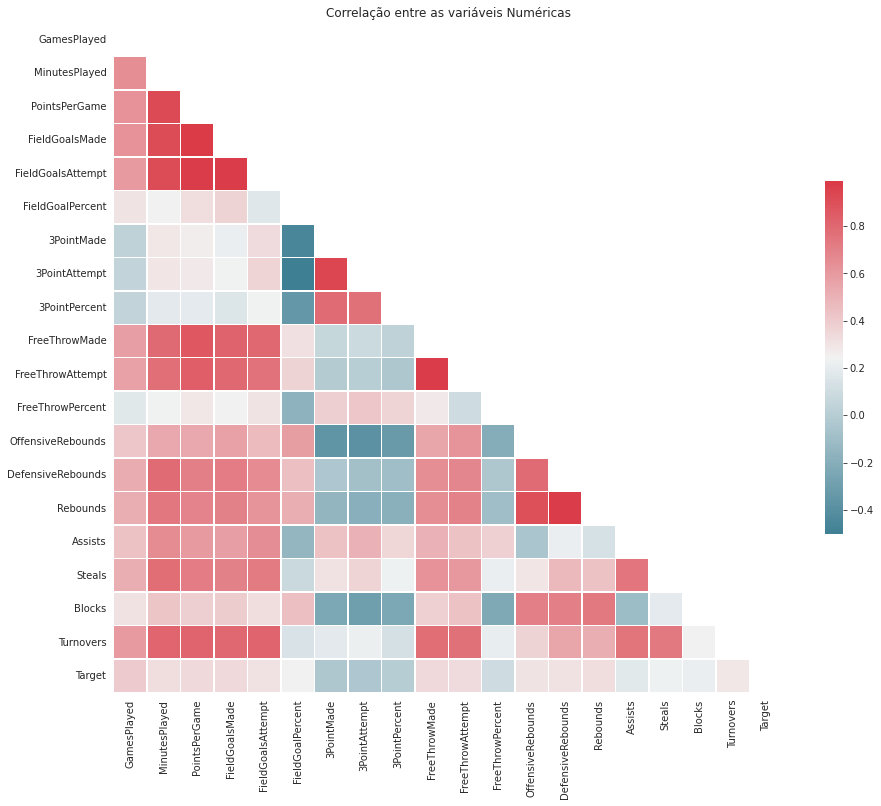

In [ ]:
# Correlação entre as variáveis

plt_correlacao_entre_vars_num(df=df_sports, col_num=col_num, method="spearman")

In [ ]:
# find groups of correlated features

correlacao_entre_vars_num(df=df_sports, col_num=col_num, method="pearson")

found 3 correlated groups in numeric variables
out of 20 total features
             feature1           feature2      corr
0      FieldGoalsMade      PointsPerGame  0.990832
1       PointsPerGame     FieldGoalsMade  0.990832
2          3PointMade      3PointAttempt  0.982674
3       3PointAttempt         3PointMade  0.982674
4    FreeThrowAttempt      FreeThrowMade  0.980445
5       FreeThrowMade   FreeThrowAttempt  0.980445
6      FieldGoalsMade  FieldGoalsAttempt  0.980261
7   FieldGoalsAttempt     FieldGoalsMade  0.980261
8   FieldGoalsAttempt      PointsPerGame  0.980093
9       PointsPerGame  FieldGoalsAttempt  0.980093
10  DefensiveRebounds           Rebounds  0.978152
11           Rebounds  DefensiveRebounds  0.978152
12           Rebounds  OffensiveRebounds  0.932459
13  OffensiveRebounds           Rebounds  0.932459
14      MinutesPlayed      PointsPerGame  0.911677
15      PointsPerGame      MinutesPlayed  0.911677
16  FieldGoalsAttempt      MinutesPlayed  0.910359
17      Mi

Analisando as correlações e tendo em vista que as variáveis possum relação com a variável alvo, vamos exluir da modelagem as seguintes variáveis:

* Rebounds: Pois a soma de DefensiveRebounds e OffensiveRebounds é igual a 

* variável Rebounds, dando alta correlação.

* 3PointAttempt: Pois é altamente correlacionada com a 3PointMade

* FieldGoalsMade: Pois é altamente correlacioanda com as variáveis PointsPerGame e FieldGoalsAttempt

* PointsPerGame: Pois é altamente correlacioanda com a variável FieldGoalsAttempt

* FreeThrowMade: Pois é altamente correlacioanda com a variável FreeThrowAttempt  

In [ ]:
df_sports_model = df_sports.drop(["Rebounds","3PointAttempt", "FieldGoalsMade", "FreeThrowMade","PointsPerGame"], axis=1)

In [ ]:
# Defininando variáveis escolhidas para modelagem e a variável alvo
col_num_model = [var for var in df_sports_model.columns if df_sports_model[var].dtype == 'float64' or df_sports_model[var].dtype == 'int64']
col_num_model.remove('Target')
y = "Target"

In [ ]:
# Observando 
df_sports_model.describe()

,GamesPlayed,MinutesPlayed,FieldGoalsAttempt,FieldGoalPercent,3PointMade,3PointPercent,FreeThrowAttempt,FreeThrowPercent,OffensiveRebounds,DefensiveRebounds,Assists,Steals,Blocks,Turnovers,Target
count,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000
mean,60.411145,17.634413,5.885542,44.184639,0.247741,19.346536,1.822139,70.325226,1.009714,2.027636,1.551205,0.619051,0.368675,1.193599,0.620482
std,17.416688,8.322560,3.595394,6.132759,0.384548,15.987119,1.322653,10.562158,0.777551,1.362236,1.475731,0.410972,0.429680,0.723966,0.485450
min,11.000000,3.100000,0.800000,23.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.100000,0.000000
25%,47.000000,10.875000,3.300000,40.200000,0.000000,0.000000,0.900000,64.700000,0.400000,1.000000,0.600000,0.300000,0.100000,0.700000,0.000000
50%,63.000000,16.100000,4.800000,44.100000,0.100000,22.450000,1.500000,71.250000,0.800000,1.700000,1.100000,0.500000,0.200000,1.000000,1.000000
75%,77.000000,22.900000,7.500000,47.900000,0.400000,32.500000,2.300000,77.600000,1.400000,2.600000,2.000000,0.800000,0.500000,1.500000,1.000000
max,82.000000,40.900000,19.800000,73.700000,2.300000,100.000000,10.200000,100.000000,5.300000,9.600000,10.600000,2.500000,3.900000,4.400000,1.000000


### Modelagem

#### Transformando dados

In [ ]:
# Separando os dados entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(df_sports_model[col_num_model],
                                                    df_sports_model[y],
                                                    test_size = 0.3,
                                                    random_state = 42)

In [ ]:
# Normalizando dados (Depois de testados, o StandarScaler funcionou melhor)
scaler = StandardScaler()
#scaler = MinMaxScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

#### Modelando

In [ ]:
model = LogisticRegression(random_state=42, penalty="none")#"none")

In [ ]:
# Fit do Modelo
model.fit(X_train_std, y_train)

LogisticRegression(penalty='none', random_state=42)

In [ ]:
# Testando com o pacote statsmodel para ter uma visão mais consolidada da análise dos parâmetros
logit_model=sm.Logit(y_train,X_train_std, random_state=42)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.595349
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.109     
Dependent Variable: Target           AIC:              1134.1588 
Date:               2022-08-06 22:46 BIC:              1201.8363 
No. Observations:   929              Log-Likelihood:   -553.08   
Df Model:           13               LL-Null:          -620.68   
Df Residuals:       915              LLR p-value:      1.9247e-22
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
--------------------------------------------------------------------
        Coef.     Std.Err.       z       P>|z|      [0.025    0.975]
--------------------------------------------------------------------
x1      0.6354      0.0973     6.5322    0.0000     0.4448    0.8261
x2     -0.4644      0.2952    -1.5731    0.1157    -1.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


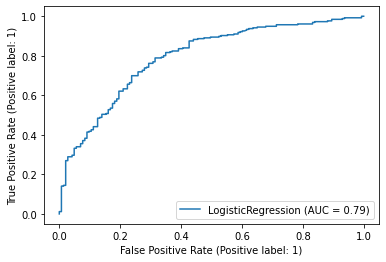

In [ ]:
# Observando a curva ROC (0.79), o modelo parece estar bem ajustado. 
metrics.plot_roc_curve(model, X_test_std, y_test) 

In [ ]:
# Predict do Modelo
y_pred = model.predict(X_test_std)

#### Avaliando o modelo

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 82,  61],
       [ 34, 222]])

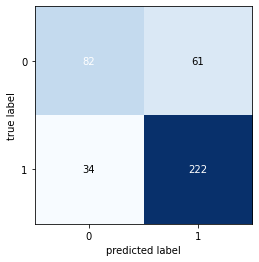

In [ ]:
plot_confusion_matrix(cm)
plt.show()

In [ ]:
# Métricas para a base de TESTE
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.57      0.63       143
           1       0.78      0.87      0.82       256

    accuracy                           0.76       399
   macro avg       0.75      0.72      0.73       399
weighted avg       0.76      0.76      0.76       399



In [ ]:
# Métricas para a base de TREINO
print(classification_report(y_train, model.predict(X_train_std)))

              precision    recall  f1-score   support

           0       0.63      0.53      0.57       361
           1       0.73      0.81      0.77       568

    accuracy                           0.70       929
   macro avg       0.68      0.67      0.67       929
weighted avg       0.69      0.70      0.69       929



### Conclusões


*   O modelo apresentou acurácia de 76% na base de teste, o que é um resultado positivo e não muito distante do resultado dos dados de treino de 70%. O mesmo pode ser dito para as demais métricas, o que nos indica a não presença de Overfitting.
*   O modelo perfomou mau para a métrica Recall para a classe 0, indicando a presença elevada de falsos negativos

#### Melhorias futuras

*   Se tivessemos um volume de dados maior, é bem provável que o modelo possa ter uma performance melhor, principalmente com mais registros de target = 0.
*   Podemos testar novos modelos





## EX2

In [ ]:
# Importando os dados
df_insurance = import_drive_file(link='https://drive.google.com/open?id=1xWMp1rhcHC-Qc4yqDkOceEAPJm5vJqHz', sep=",")

1xWMp1rhcHC-Qc4yqDkOceEAPJm5vJqHz


### EDA

#### Tratamento dos Dados


In [ ]:
df_insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
# Por existirem variáveis categóricas, vamos já transforma-las para facilitar as análises e a modelagem

encoder=ce.OneHotEncoder(cols=['sex','smoker','region'], handle_unknown='return_nan',return_df=True,use_cat_names=True)
df_insurance_encoded = encoder.fit_transform(df_insurance)
df_insurance = pd.merge(df_insurance,df_insurance_encoded[['sex_female','sex_male','smoker_yes','smoker_no','region_southwest','region_southeast','region_northwest','region_northeast']], left_index=True, right_index=True)
df_insurance.head()

,age,sex,bmi,children,smoker,region,charges,sex_female,sex_male,smoker_yes,smoker_no,region_southwest,region_southeast,region_northwest,region_northeast
0,19,female,27.900,0,yes,southwest,16884.92400,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,18,male,33.770,1,no,southeast,1725.55230,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,28,male,33.000,3,no,southeast,4449.46200,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,33,male,22.705,0,no,northwest,21984.47061,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,32,male,28.880,0,no,northwest,3866.85520,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


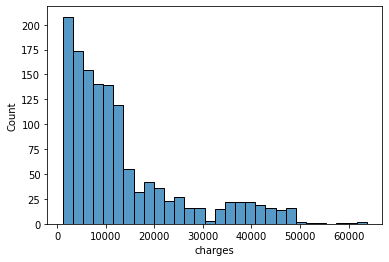

In [ ]:
# No segundo modelo, vamos aplicar um modelo de classificação. Para isso, devemos criar variável target com base na coluna charge.
sns.histplot(data=df_insurance, x="charges")

In [ ]:
# Criando a variável "charges_class" com base nos quartis da variável charges
Quantiles = df_insurance[['charges']].quantile([0.25, 0.50, 0.75, 1.])
Quantiles = Quantiles.to_dict()
charges_class = df_insurance[['charges']]

charges_class['charges'] = np.where(charges_class['charges'] <= Quantiles['charges'][0.25], 1,
                                    np.where((charges_class['charges'] > Quantiles['charges'][0.25]) & (charges_class['charges'] <= Quantiles['charges'][0.5]), 2,
                                             np.where((charges_class['charges'] > Quantiles['charges'][0.5]) & (charges_class['charges'] <= Quantiles['charges'][0.75]), 3, 4)))
    
df_insurance['charges_class'] = charges_class
df_insurance.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,age,sex,bmi,children,smoker,region,charges,sex_female,sex_male,smoker_yes,smoker_no,region_southwest,region_southeast,region_northwest,region_northeast,charges_class
0,19,female,27.900,0,yes,southwest,16884.92400,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,4
1,18,male,33.770,1,no,southeast,1725.55230,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1
2,28,male,33.000,3,no,southeast,4449.46200,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1
3,33,male,22.705,0,no,northwest,21984.47061,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,4
4,32,male,28.880,0,no,northwest,3866.85520,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1


In [ ]:
# Tranforma a coluna criada para String
df_insurance['charges_class'] = df_insurance['charges_class'].apply(str)

In [ ]:
# É possível observar que por conta de usarmos o método de quartis para criar as classes, estas se encontram balanceadas
df_insurance["charges_class"].value_counts(normalize=True)

4    0.250374
1    0.250374
2    0.249626
3    0.249626
Name: charges_class, dtype: float64

In [ ]:
# Separa variáveis numéricas para facilitar análises quando necessário
col_num_insu = [var for var in df_insurance.columns if df_insurance[var].dtype == 'float64' or df_insurance[var].dtype == 'int64']
col_cat_insu = [var for var in df_insurance.columns if df_insurance[var].dtype == 'object']

In [ ]:
df_insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   sex               1338 non-null   object 
 2   bmi               1338 non-null   float64
 3   children          1338 non-null   int64  
 4   smoker            1338 non-null   object 
 5   region            1338 non-null   object 
 6   charges           1338 non-null   float64
 7   sex_female        1338 non-null   float64
 8   sex_male          1338 non-null   float64
 9   smoker_yes        1338 non-null   float64
 10  smoker_no         1338 non-null   float64
 11  region_southwest  1338 non-null   float64
 12  region_southeast  1338 non-null   float64
 13  region_northwest  1338 non-null   float64
 14  region_northeast  1338 non-null   float64
 15  charges_class     1338 non-null   object 
dtypes: float64(10), int64(2), object(4)
memory

In [ ]:
# O dataframe possui 1.338 linhas e 16 colunas no total
df_insurance.shape

(1338, 16)

In [ ]:
# Verifica valores duplicados
df_insurance.duplicated().value_counts()

False    1337
True        1
dtype: int64

In [ ]:
# Como só temos apenas 1 registro duplicado, vamos remove-lo
df_insurance.drop_duplicates(keep='first', inplace=True)

In [ ]:
# Não temos dados nulos
df_insurance.isna().sum()

age                 0
sex                 0
bmi                 0
children            0
smoker              0
region              0
charges             0
sex_female          0
sex_male            0
smoker_yes          0
smoker_no           0
region_southwest    0
region_southeast    0
region_northwest    0
region_northeast    0
charges_class       0
dtype: int64

In [ ]:
df_insurance.describe()

,age,bmi,children,charges,sex_female,sex_male,smoker_yes,smoker_no,region_southwest,region_southeast,region_northwest,region_northeast
count,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487,0.495138,0.504862,0.204936,0.795064,0.243082,0.272251,0.242334,0.242334
std,14.044333,6.100468,1.205571,12110.359656,0.500163,0.500163,0.403806,0.403806,0.429104,0.445285,0.428655,0.428655
min,18.000000,15.960000,0.000000,1121.873900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,26.290000,0.000000,4746.344000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,30.400000,1.000000,9386.161300,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,51.000000,34.700000,2.000000,16657.717450,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,64.000000,53.130000,5.000000,63770.428010,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Análise Gráfica

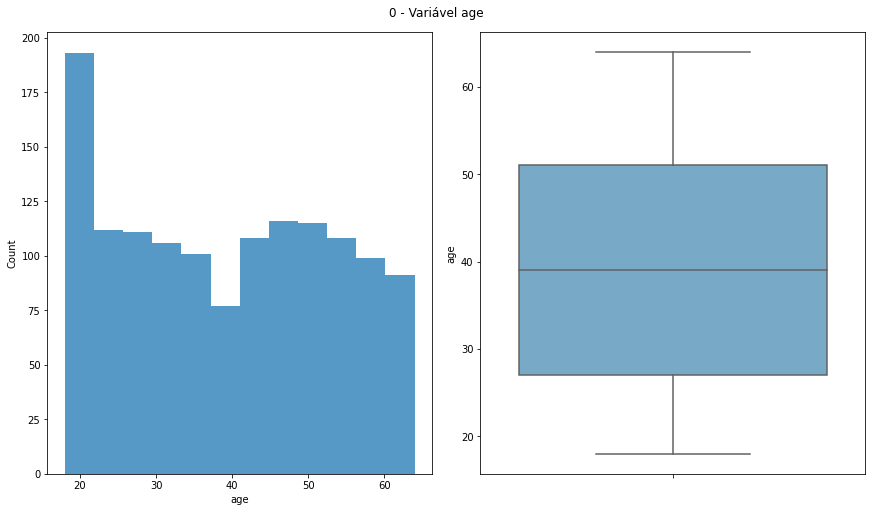

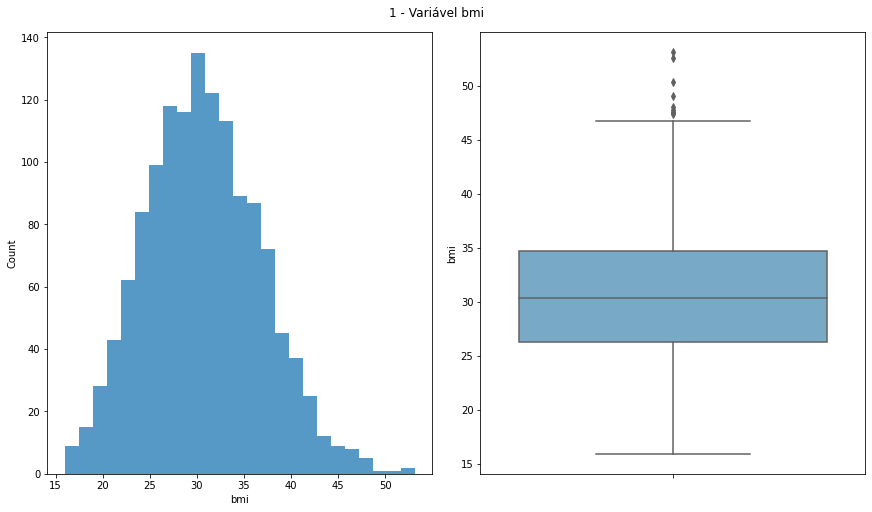

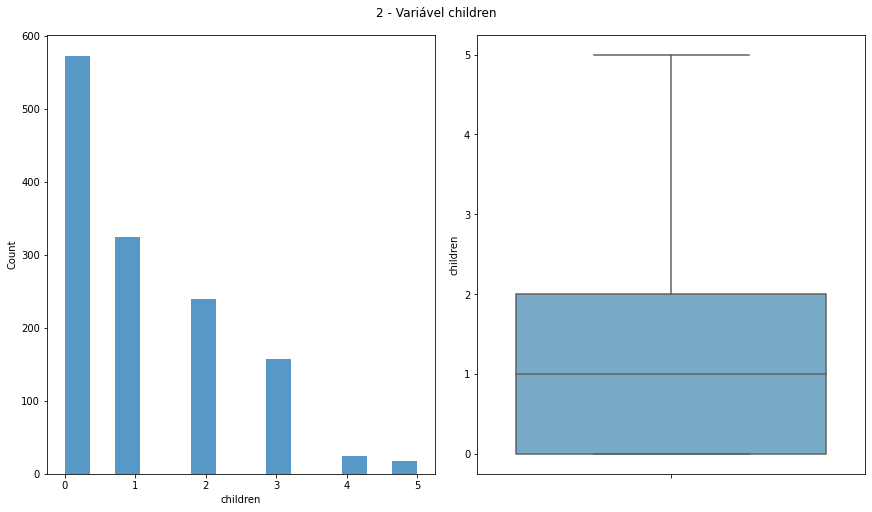

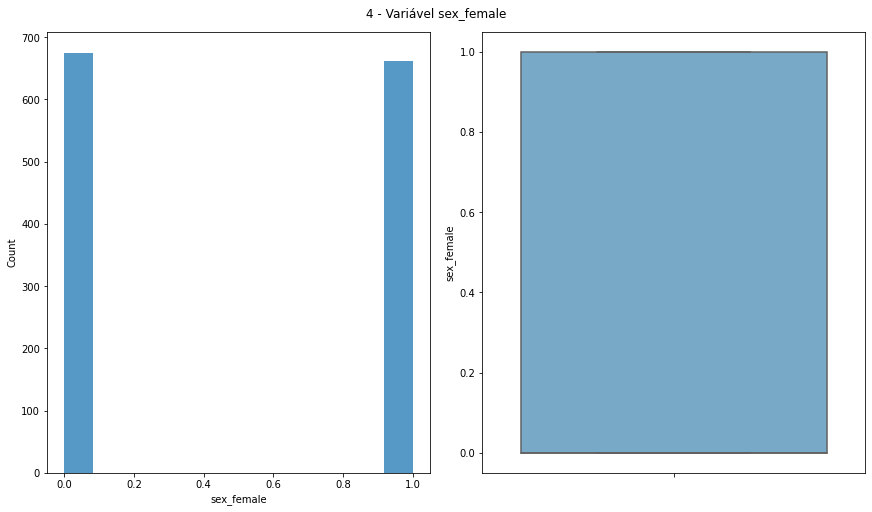

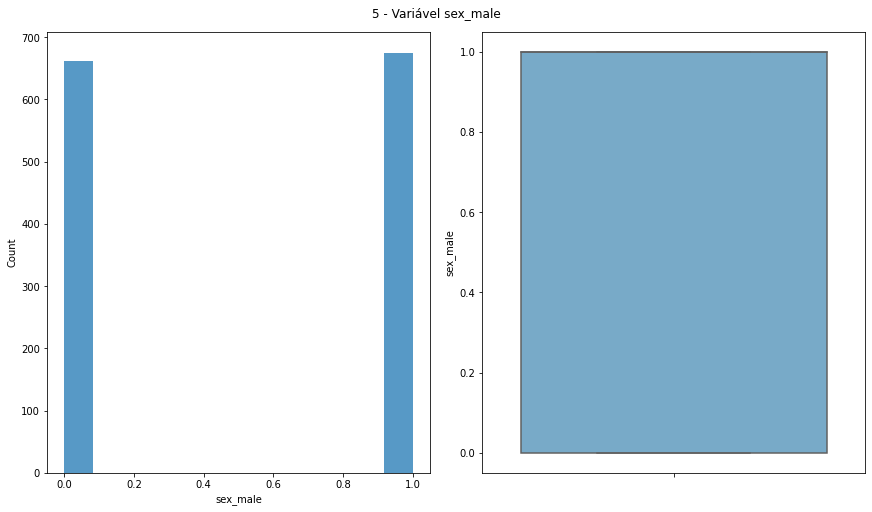

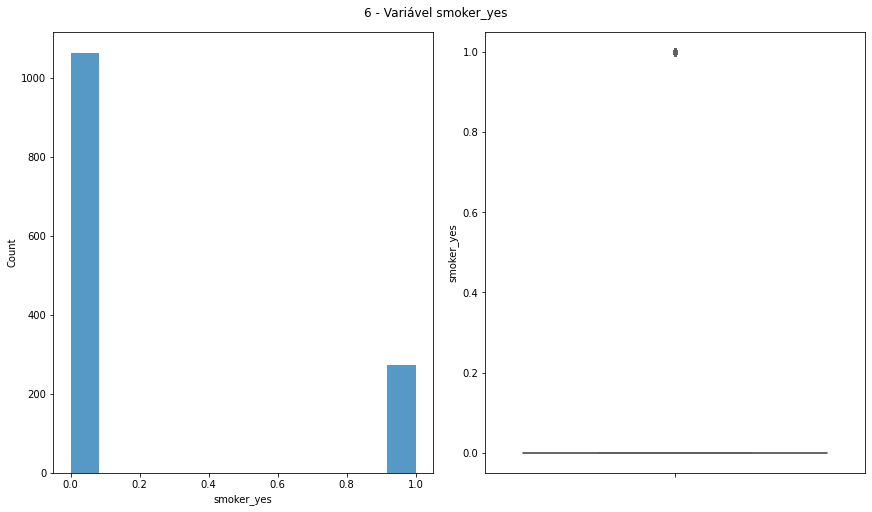

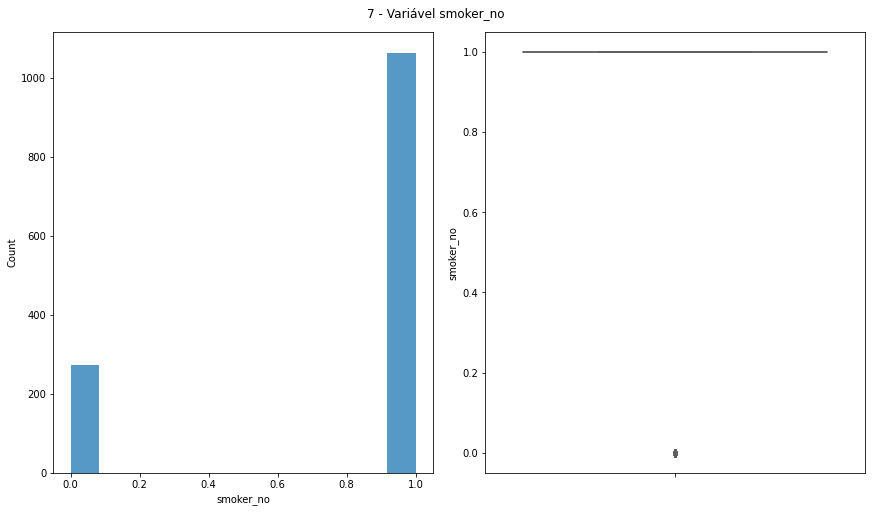

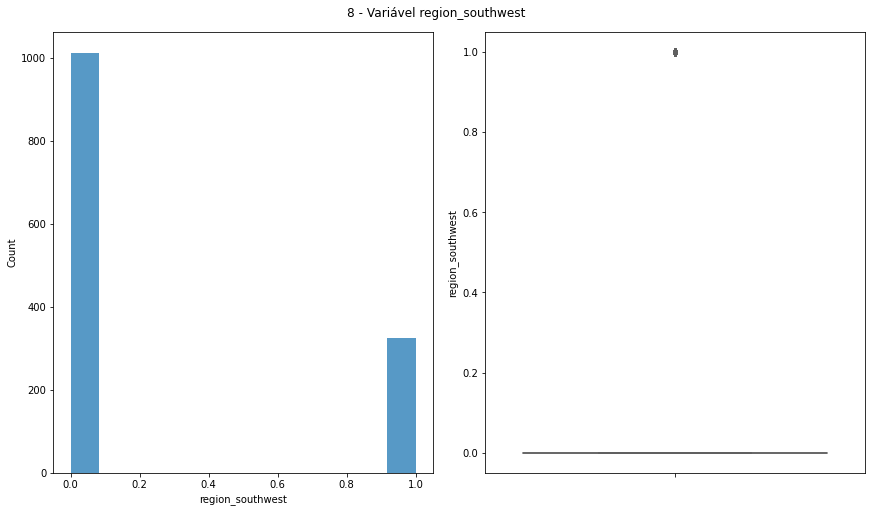

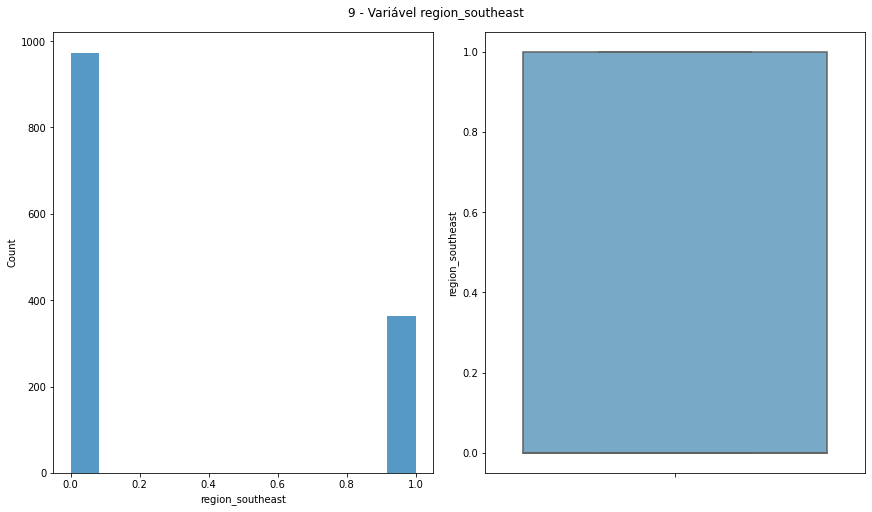

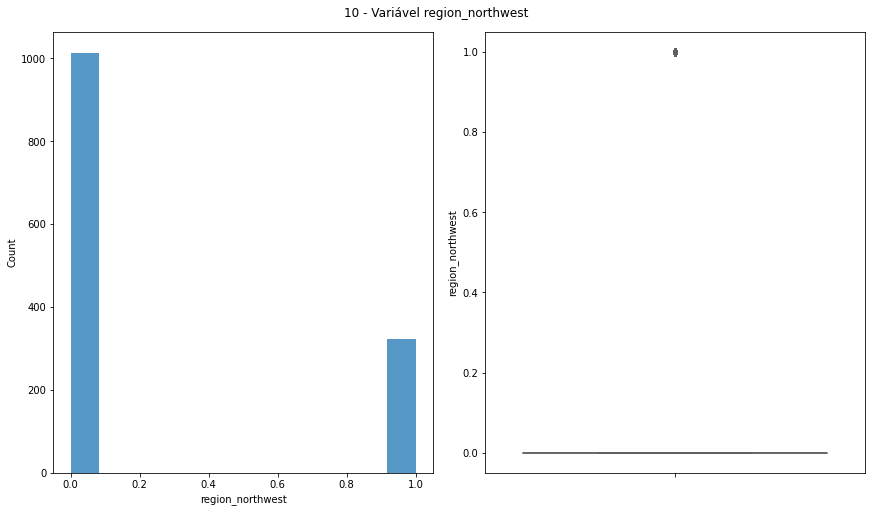

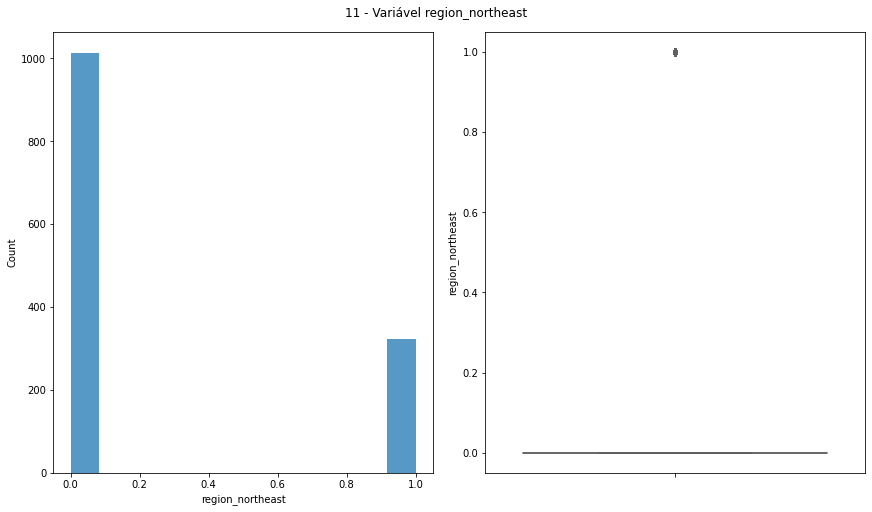

In [ ]:
# Os gráfico abaixo mostra a distribuição das variáveis
for i, var in enumerate(col_num_insu):
    if var != 'charges':
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 7), constrained_layout=True)

        #df_insurance.groupby(var)['charges'].value_counts(normalize=True).unstack('charges').plot.bar(stacked=True, ax=ax3)
        sns.histplot(df_insurance,x=var, lw=0., ax=ax1)
        sns.boxplot(data=df_insurance, y=var,  palette="Blues", ax=ax2)
        fig.suptitle('{0} - Variável {1}'.format(i, var))
        plt.show()

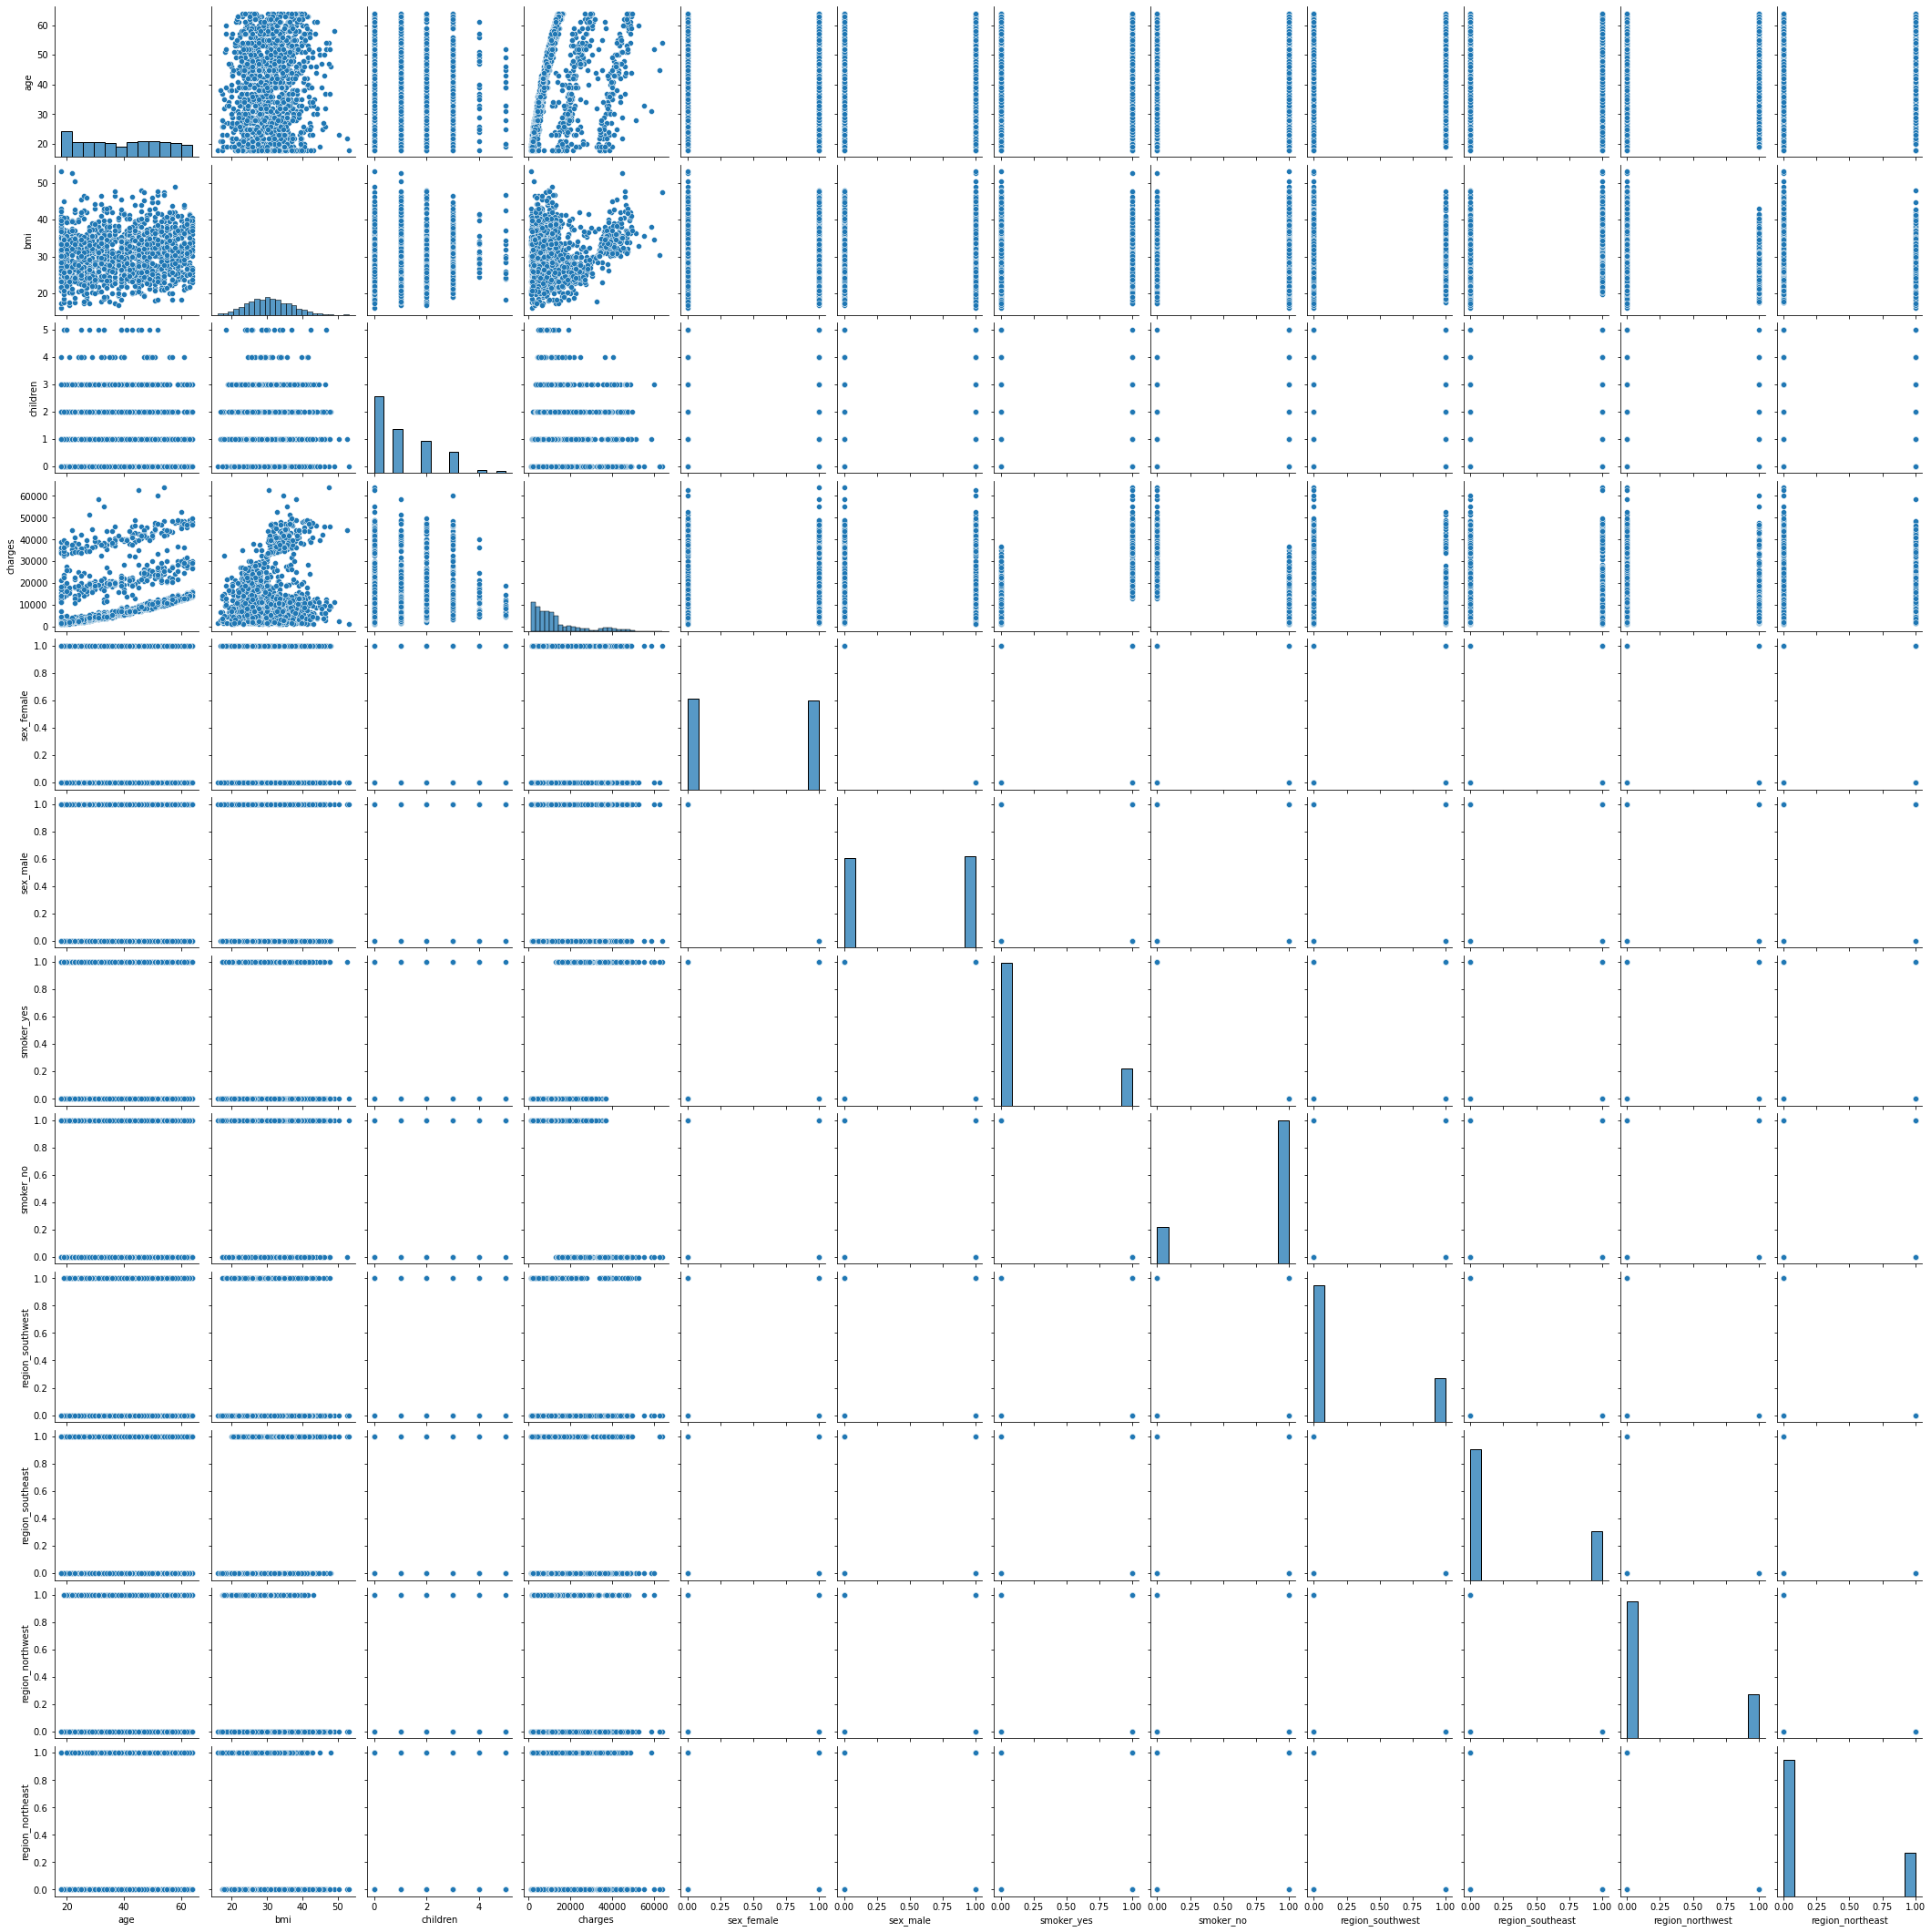

In [ ]:
# Analisando a distribuição das variáveis sem a variável Target
#df_insurance[col_num_insu].hist(figsize=(20,20))
#plt.show()
sns.pairplot(df_insurance[col_num_insu])
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


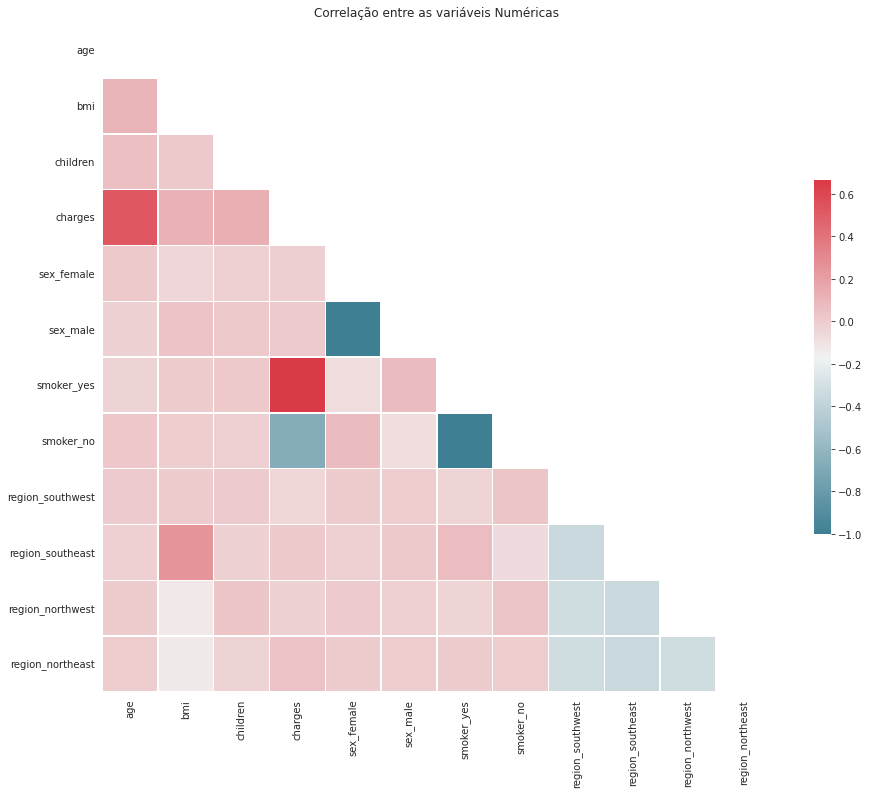

In [ ]:
# Correlação entre as variáveis

plt_correlacao_entre_vars_num(df=df_insurance, col_num=col_num_insu, method="spearman")

In [ ]:
# find groups of correlated features

correlacao_entre_vars_num(df=df_insurance, col_num=col_num_insu, method="pearson")

found 1 correlated groups in numeric variables
out of 16 total features
     feature1    feature2  corr
0  smoker_yes   smoker_no   1.0
1   smoker_no  smoker_yes   1.0
[     feature1   feature2  corr
0  smoker_yes  smoker_no   1.0]


In [ ]:
col_num_insu

['age',
 'bmi',
 'children',
 'charges',
 'sex_female',
 'sex_male',
 'smoker_yes',
 'smoker_no',
 'region_southwest',
 'region_southeast',
 'region_northwest',
 'region_northeast']

In [ ]:
col_num_model_reg = ['age', 'bmi', 'children', 'sex_female', 'smoker_yes', 'region_southwest', 'region_southeast', 'region_northwest', 'region_northeast']
y_reg = ['charges']

### Modelagem - Regresão

In [ ]:
# Separando os dados entre treino e teste
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(df_insurance[col_num_model_reg],
                                                    df_insurance[y_reg],
                                                    test_size = 0.3,
                                                    random_state = 42)

#### Transformando dados

In [ ]:
# Normalizando dados (Depois de testados, o StandarScaler funcionou melhor)
scaler = StandardScaler()
#scaler = MinMaxScaler()

X_train_r_std = scaler.fit_transform(X_train_r)
X_test_r_std = scaler.transform(X_test_r)

#### Modelando

In [ ]:
model_r = LinearRegression()#"none")

In [ ]:
# Fit do Modelo
model_r.fit(X_train_r_std, y_train_r)

LinearRegression()

#### Avaliando o modelo

In [ ]:
# Predict do Modelo
y_pred_r = model_r.predict(X_test_r_std)

In [ ]:
# Calculando o R2

R2_2 = r2_score(y_test_r, y_pred_r)

# Mostra o resultado
print("R2 : ", R2_2)

R2 :  0.7724363518631285


Text(0.5, 0, 'Predict Value')

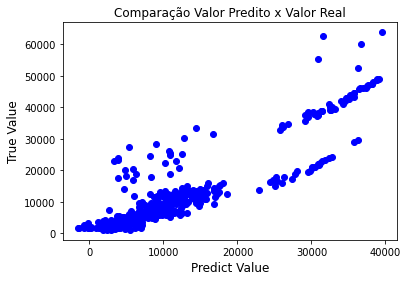

In [ ]:
plt.plot(y_pred_r, y_test_r, 'bo')
plt.title('Comparação Valor Predito x Valor Real', fontsize=12)
plt.ylabel("True Value", fontsize=12)
plt.xlabel("Predict Value", fontsize=12)

In [ ]:
# Aqui é possível obversar que a variável SMOKER=yes é a mais importane na regressão, seguida da AGE e do BMI,
# O que faz bastante sentido em se tratando de uma base de dados de seguros (imagino ser seguro de vida), ou seja, o fato da pessoa fumar impacta negativamente na sua saúde, fazendo com que tenha que pagar mais pelo seguro de vida.
coef_table = pd.DataFrame(list(X_train_r.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",model_r.coef_.transpose())
coef_table = coef_table.sort_values(by = ['Coefs'], ascending = False)
coef_table

,0,Coefs
4,smoker_yes,9275.748193
0,age,3515.420056
1,bmi,1977.132349
2,children,625.171278
8,region_northeast,233.675055
3,sex_female,55.894378
7,region_northwest,37.635947
5,region_southwest,-91.846352
6,region_southeast,-170.148144


In [ ]:
coef_table = pd.DataFrame(list(X_train_std.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",model_lin.coef_.transpose())
coef_table = coef_table.sort_values(by = ['Coefs'], ascending = False)
coef_table

### Modelagem - Classificação

In [ ]:
col_num_model_class = ['age', 'bmi', 'children', 'sex_female', 'smoker_yes', 'region_southwest', 'region_southeast', 'region_northwest', 'region_northeast']
y_class = ['charges_class']

In [ ]:
# Separando os dados entre treino e teste
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(df_insurance[col_num_model_class],
                                                    df_insurance[y_class],
                                                    test_size = 0.3,
                                                    random_state = 42)

#### Transformando dados

In [ ]:
# Normalizando dados (Depois de testados, o StandarScaler funcionou melhor)
scaler = StandardScaler()
#scaler = MinMaxScaler()

X_train_c_std = scaler.fit_transform(X_train_c)
X_test_c_std = scaler.transform(X_test_c)

#### Modelando

In [ ]:
model_c = LogisticRegression(random_state=42)#"none")

In [ ]:
# Fit do Modelo
model_c.fit(X_train_c_std, y_train_c)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=42)

#### Avaliando o modelo

In [ ]:
# Predict do Modelo
y_pred_c = model_c.predict(X_test_c_std)

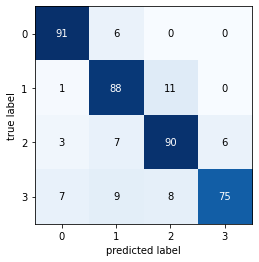

In [ ]:
cm = confusion_matrix(y_test_r, y_pred_r)
plot_confusion_matrix(cm)
plt.show()

In [ ]:
# Métricas para a base de TESTE
print(classification_report(y_test_c, y_pred_c))

              precision    recall  f1-score   support

           1       0.89      0.94      0.91        97
           2       0.80      0.88      0.84       100
           3       0.83      0.85      0.84       106
           4       0.93      0.76      0.83        99

    accuracy                           0.86       402
   macro avg       0.86      0.86      0.86       402
weighted avg       0.86      0.86      0.86       402



In [ ]:
# Métricas para a base de TREINO
print(classification_report(y_train_c, model_c.predict(X_train_c_std)))

              precision    recall  f1-score   support

           1       0.89      0.92      0.91       237
           2       0.83      0.87      0.85       234
           3       0.77      0.84      0.80       228
           4       0.92      0.76      0.84       236

    accuracy                           0.85       935
   macro avg       0.85      0.85      0.85       935
weighted avg       0.85      0.85      0.85       935



### Conclusões

*   O modelo de regressão linear ficou com $R^2$ de 77%, muito impactado pelas variáveis fumante, idade e bmi. Isso faz bastante sentido, tendo em vista que a variável target diz respeito ai valor que uma pessoa deve pagar para obter um seguro de vida. Ou seja, quando maior a idade, bmi e o fato fumar, menor a expectativa de vida.
*   O modelo de regressão ficou com 86% de acurácia, sem viés forte de erro para cada classe (que foi criada com base nos quartis da variável charges). Além disso, quando comparamos os resultados do treino e do teste não há muita diferença, o que indica a não presenã de overfitting.